在许多商业活动中,季节因素、假期因素等对商家的销售活动会起到很大的影响，如淡季、旺季、十一，五一、春节等假期都会商家的销售额产生很大的影响。如何能让我们的模型从数据的时间序列中捕捉到这种有规律的时间的变化特征，从而为我们提供更加准确的预测，这正是本文所要讨论的主要内容。
这里我们将使用facebook的时间序列预测框架Prophet(https://facebook.github.io/prophet/), 关于安装Prophet方法可以看这篇博客:https://blog.csdn.net/qq_23860475/article/details/81354467

prophet是一种基于附加模型预测时间序列数据的过程，其中非线性趋势与年，周和日的季节性变化以及假日效应相吻合。它最适合具有强烈季节性影响和多个季节历史数据的时间序列。prophet对丢失数据和趋势变化具有鲁棒性，通常可以很好地处理异常值。

在本文中，我们将使用时间序列分析技术来分析国外某商家的历史销售数据,并使用prophet来预测商家未来5周的销售额，你可以在这里下载我们的数据

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF
import datetime
import warnings
warnings.filterwarnings("ignore")

# 数据说明

* Store: 商家编码，这里总共有9个商家(1号-10号,中间缺9号)
* Product：商品编码,总共有3个商品
* Is_Holiday：该周是否包含假期的指标：0 =否，1 =是
* Base Price：日常基准价格(未打折扣)
* Price：每周的实际价格。 如果是促销时期那就是促销价格，否则就是日常基准价格。
* Weekly_Units_Sold：每周的销售数量

In [4]:
df = pd.read_csv('./data/Sales.csv')
df.head()

,Store,Product,Date,Is_Holiday,Base Price,Price,Weekly_Units_Sold
0,1,1,2/5/2010,False,9.99,7.99,245
1,1,1,2/12/2010,True,9.99,7.99,453
2,1,1,2/19/2010,False,9.99,7.99,409
3,1,1,2/26/2010,False,9.99,7.99,191
4,1,1,3/5/2010,False,9.99,9.99,145


下面我们对数据进行预处理，我们增加一个weekly_sales(每周销售额)，year，month，day，week_of_year等字段。

In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

df['weekly_sales'] = df['Price'] * df['Weekly_Units_Sold']
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['week_of_year'] = df.index.weekofyear

In [6]:
df.head()

,Store,Product,Is_Holiday,Base Price,Price,Weekly_Units_Sold,weekly_sales,year,month,day,week_of_year
Date,,,,,,,,,,,
2010-02-05,1,1,False,9.99,7.99,245,1957.55,2010,2,5,5
2010-02-12,1,1,True,9.99,7.99,453,3619.47,2010,2,12,6
2010-02-19,1,1,False,9.99,7.99,409,3267.91,2010,2,19,7
2010-02-26,1,1,False,9.99,7.99,191,1526.09,2010,2,26,8
2010-03-05,1,1,False,9.99,9.99,145,1448.55,2010,3,5,9


# EDA

为了对数据有一个初步印象，在这里我们将会对数据进行可视化，我们将会画ECDF(经验分布函数)图(https://baike.baidu.com/item/%E6%A0%B7%E6%9C%AC%E5%88%86%E5%B8%83%E5%87%BD%E6%95%B0/18885457?fromtitle=%E7%BB%8F%E9%AA%8C%E5%88%86%E5%B8%83%E5%87%BD%E6%95%B0&fromid=7655582&fr=aladdin)


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Store,3861.0,5.111111,2.767003,1.00,3.00,5.00,7.00,10.00
Product,3861.0,2.000000,0.816602,1.00,1.00,2.00,3.00,3.00
Base Price,3861.0,12.554103,6.079043,5.99,6.99,10.99,19.99,21.99
Price,3861.0,11.766084,5.976196,4.01,5.99,10.00,19.99,21.99
Weekly_Units_Sold,3861.0,215.952603,236.273397,13.00,69.00,130.00,278.00,2557.00
weekly_sales,3861.0,1896.054685,1789.384621,229.77,778.70,1476.72,2330.11,25570.00
year,3861.0,2010.965035,0.797061,2010.00,2010.00,2011.00,2012.00,2012.00
month,3861.0,6.447552,3.238476,1.00,4.00,6.00,9.00,12.00
day,3861.0,15.678322,8.756234,1.00,8.00,16.00,23.00,31.00
week_of_year,3861.0,25.818182,14.129933,1.00,14.00,26.00,38.00,52.00


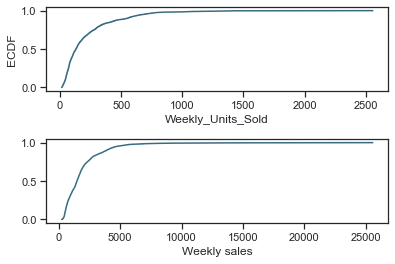

In [8]:
sns.set(style = "ticks")
c = '#386B7F' 
figure, axes = plt.subplots(nrows=2, ncols=2)
figure.tight_layout(pad=2.0)
plt.subplot(211)
cdf = ECDF(df['Weekly_Units_Sold'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Weekly_Units_Sold'); plt.ylabel('ECDF');

plt.subplot(212)
cdf = ECDF(df['weekly_sales'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Weekly sales');

从上图中我们可以发现：
* 1.尽管周的销售数量最大查过了2500，但是80%的数据中周销售数量都在500以内。
* 2.尽管周的销售金额最大超过了25K,但是90%的数据中周销售金额都在5K以内。

下面我们对Store，weekly_sales，Weekly_Units_Sold进行分组统计：

In [9]:
df.groupby('Store')['weekly_sales'].describe()

,count,mean,std,min,25%,50%,75%,max
Store,,,,,,,,
1,429.0,1789.414172,900.074226,769.65,1208.90,1659.17,1957.20,6816.59
2,429.0,2469.447413,1328.162884,1143.48,1579.21,2215.08,2756.55,9110.00
3,429.0,670.924009,366.816321,229.77,459.77,619.69,730.78,2650.00
4,429.0,3078.462145,1746.147872,1099.45,1818.18,2626.61,3837.51,13753.12
5,429.0,588.922984,242.628977,285.87,461.23,519.74,613.53,2264.97
6,429.0,2066.705082,1163.284768,890.19,1418.58,1758.40,2156.40,7936.03
7,429.0,955.115058,489.084883,389.61,649.35,857.61,1041.51,3270.00
8,429.0,1352.094056,811.326288,516.53,846.23,1275.87,1491.51,6656.67
10,429.0,4093.407249,3130.087191,1483.65,2462.88,3707.81,4510.47,25570.00


In [10]:
df.groupby('Store')['Weekly_Units_Sold'].sum()

Store
1      86699
2     121465
3      31689
4     158718
5      27300
6      97698
7      44027
8      65273
10    200924
Name: Weekly_Units_Sold, dtype: int64

从上面的统计结果中我们可以看到：
* 1.在所有的商家中商家10的平均销售金额和销售数量都是最大的。
* 2.在所有的商家中商家5的平均销售金额和销售数量都是最小的。

下面我们按是否节假日来查看商品的销售价格和销售数量的分布：

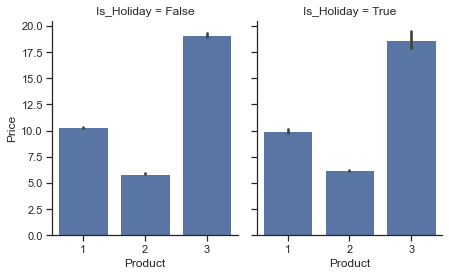

In [11]:
g = sns.FacetGrid(df, col="Is_Holiday", height=4, aspect=.8)
g.map(sns.barplot, "Product", "Price");

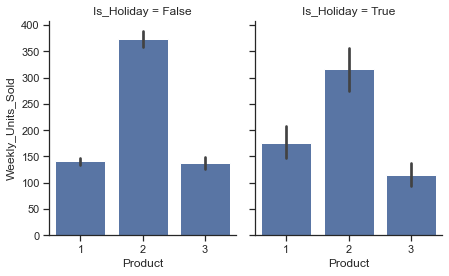

In [12]:
g = sns.FacetGrid(df, col="Is_Holiday", height=4, aspect=.8)
g.map(sns.barplot, "Product", "Weekly_Units_Sold");

从上面的分布图中可以看见：
* 1.无论是否假期,商品2的销售价格在所有的商品中是最低的,而商品3的价格是最高的。
* 2.无论是否假期商品2的销售数量是最高的。
* 3.当假期时商品3的销售量是最低的，而非假期时商品3和商品1的销售量相差无几。

从中我们可以总结出商品的销售价格在假期和非假期时没有太大变化，商品的销售数量在假期和非假期时有略微的差异

下面我们查看密度分布图

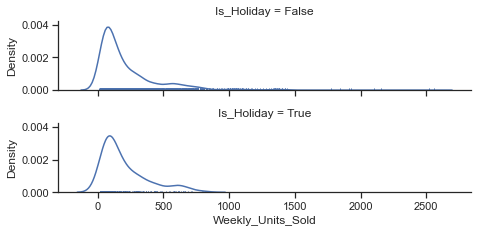

In [13]:
g = sns.FacetGrid(df, row="Is_Holiday",
                  height=1.7, aspect=4,)
g.map(sns.distplot, "Weekly_Units_Sold", hist=False, rug=True);

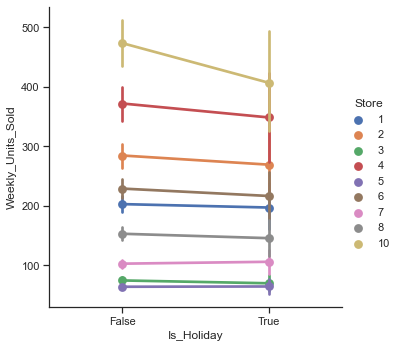

In [14]:
sns.factorplot(data= df, x= 'Is_Holiday',y= 'Weekly_Units_Sold',hue= 'Store');

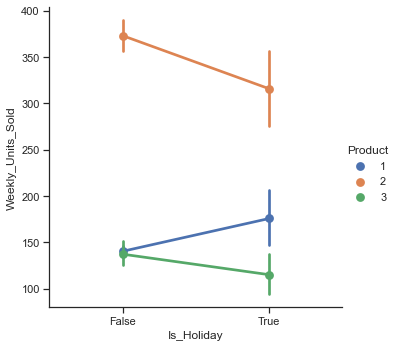

In [15]:
sns.factorplot(data= df, x= 'Is_Holiday',y= 'Weekly_Units_Sold',hue= 'Product');

从上图中我们可以看见：
* 1.大多数商家在节假日的平均销售数量与日常的平均销售量相差不大,而商家10在节假日的销售量有明显的减少
* 2.商品1在节假日平均销售数量明显增加，而商品2和商品3在节假日的平均销售数量有较为明显的减少

下面我们查看每种商品的销售价格和销售数量的散点图：

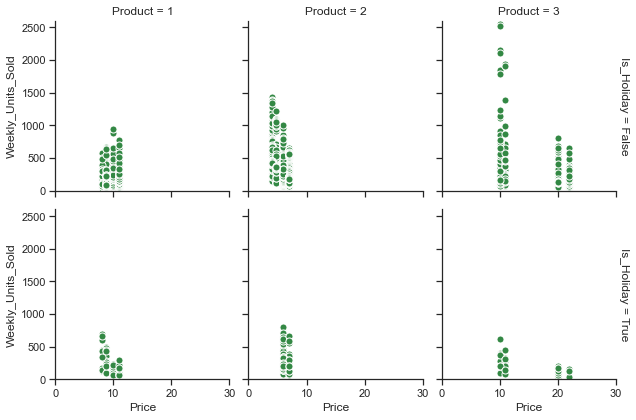

In [16]:
g = sns.FacetGrid(df, col="Product", row="Is_Holiday", margin_titles=True, height=3)
g.map(plt.scatter, "Price", "Weekly_Units_Sold", color="#338844", edgecolor="white", s=50, lw=1)
g.set(xlim=(0, 30), ylim=(0, 2600));

从上面的散点图中我们可以看见：

* 1.每个商品在假期或非假期期间都有至少2个或以上的价格，除商品3以外,其他商品的多个价格直接的差异都比较小，而商品3的价格差异较大(有50%的差异)
* 2.商品3在非假期期间的销售量最高。

下面我们查看每个商家的销售价格和销售数量的散点图：

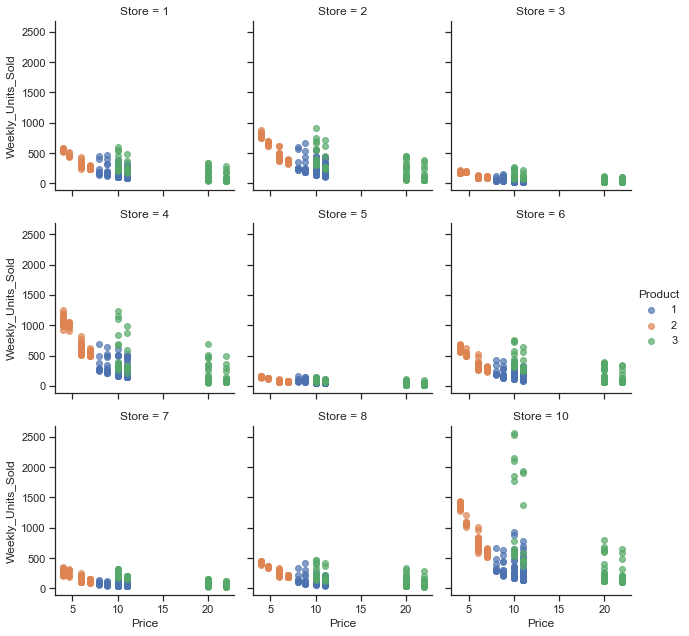

In [17]:
g = sns.FacetGrid(df, col="Store", hue="Product", margin_titles=True, col_wrap=3)
g.map(plt.scatter, 'Price', 'Weekly_Units_Sold', alpha=.7)
g.add_legend();

从上面的散点图中我们可以看见：

* 所有的9个商家都销售商品1、商品2、商品3这三种商品，而商品3在所有商家都存在打折销售的情况，并且在商家10的销售量最大。

下面我们按月份查看每个商家销售数量的点图：

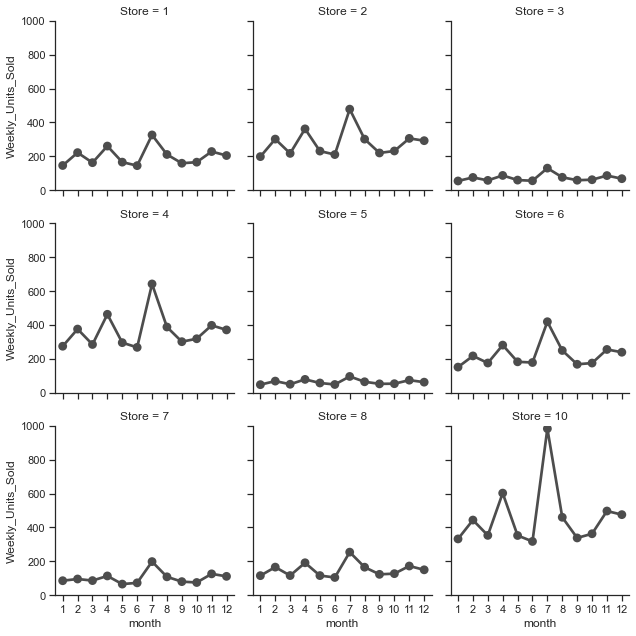

In [18]:
g = sns.FacetGrid(df, col="Store", col_wrap=3, height=3, ylim=(0, 1000))
g.map(sns.pointplot, "month", "Weekly_Units_Sold", color=".3", ci=None, order = [1,2,3,4,5,6,7,8,9,10,11,12]);

从上面的散点图中我们可以看见：
* 1.每个商家的销售数量都呈现出季节性的波动,7月份销售数量最大，商家10在7月的销售数量是最大的。

下面我们查看商品的点图：

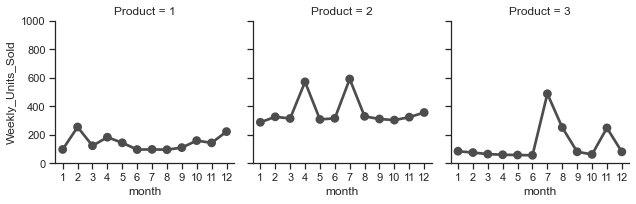

In [19]:
g = sns.FacetGrid(df, col="Product", col_wrap=3, height=3, ylim=(0, 1000))
g.map(sns.pointplot, "month", "Weekly_Units_Sold", color=".3", ci=None, order = [1,2,3,4,5,6,7,8,9,10,11,12]);

从上面的图中我们发现：
* 1.商品1受季节性影响较小,商品2在4月和7月有两个销售高峰,商品3在7月是销售数量最高峰,其次在11月份也有一个小高峰

下面我们按商家来查看所有的3中商品的销售情况：

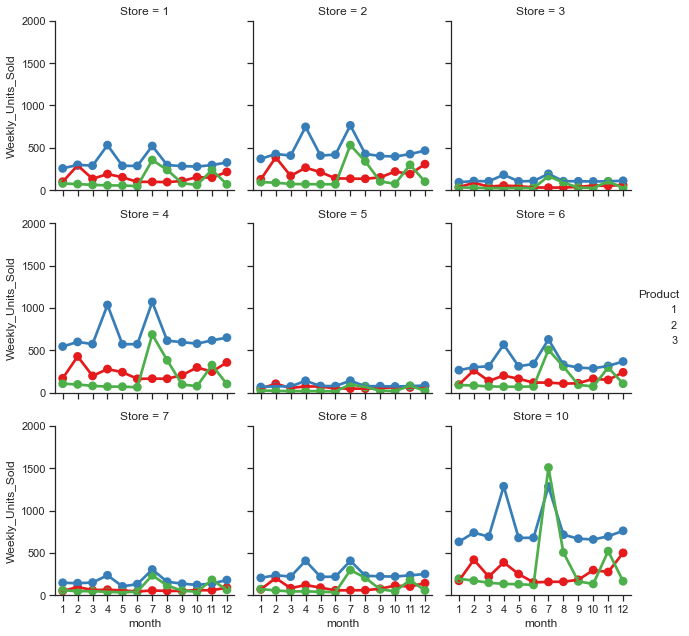

In [20]:
g = sns.FacetGrid(df, col="Store", col_wrap=3, height=3, ylim=(0, 2000), hue='Product', palette="Set1")
g.map(sns.pointplot, "month", "Weekly_Units_Sold", ci=None, order = [1,2,3,4,5,6,7,8,9,10,11,12], alpha=.7)
g.add_legend();


从上面的图中我们发现：
* 1.商品2(蓝色曲线)在大多数时间在所有商家中的销售量是最高的。
* 2 商家10中在7月份的时候商品3(绿色曲线)的销售量超过了商品2

下面我们查看价格和是否假期的散点回归图：

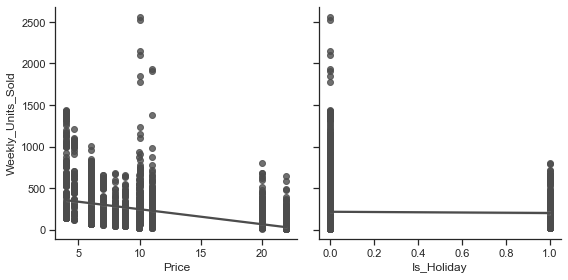

In [21]:
g = sns.PairGrid(df, y_vars=["Weekly_Units_Sold"], x_vars=["Price", "Is_Holiday"], height=4)
g.map(sns.regplot, color=".3");

从上图上我们发现：
* 1.商品价格越便宜,销售量越大
* 2.非假期的销售量要高于假期的销售量

下面我为数据集增加一个promotion字段，用来识别当前的price是否是优惠价。

In [22]:
def f(row):
    if row['Base Price'] == row['Price']:
        val = 0
    elif row['Base Price'] > row['Price']:
        val = 1
    else:
        val = -1
    return val
df['promotion'] = df.apply(f, axis=1)

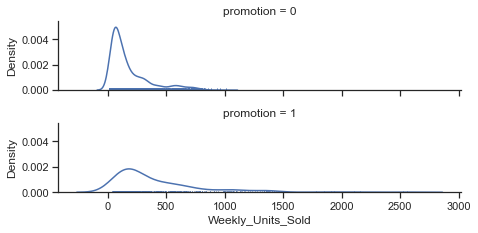

In [23]:
g = sns.FacetGrid(df, row="promotion",
                  height=1.7, aspect=4,)
g.map(sns.distplot, "Weekly_Units_Sold", hist=False, rug=True);

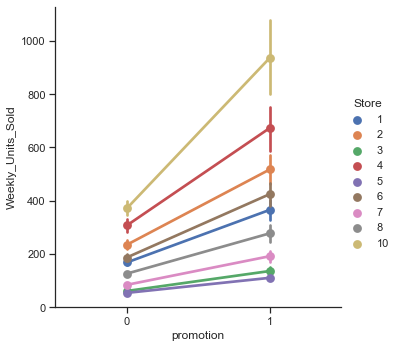

In [24]:
sns.factorplot(data= df, x= 'promotion',y= 'Weekly_Units_Sold',hue= 'Store');

从上图中我们发现：
* 所有的商家在优惠期间的销售量都有所上升

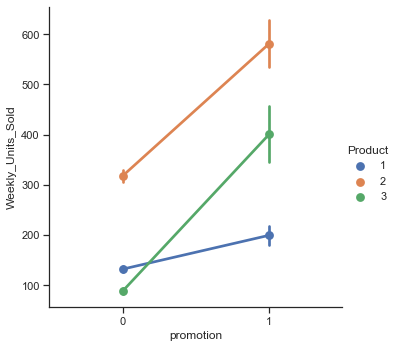

In [25]:
sns.factorplot(data= df, x= 'promotion',y= 'Weekly_Units_Sold',hue= 'Product');

从上图中我们发现：
* 所有的商品在优惠期间的销售量都有所上升

下面我们查看10个商家在优惠和非优惠的情况下的销售量的情况：

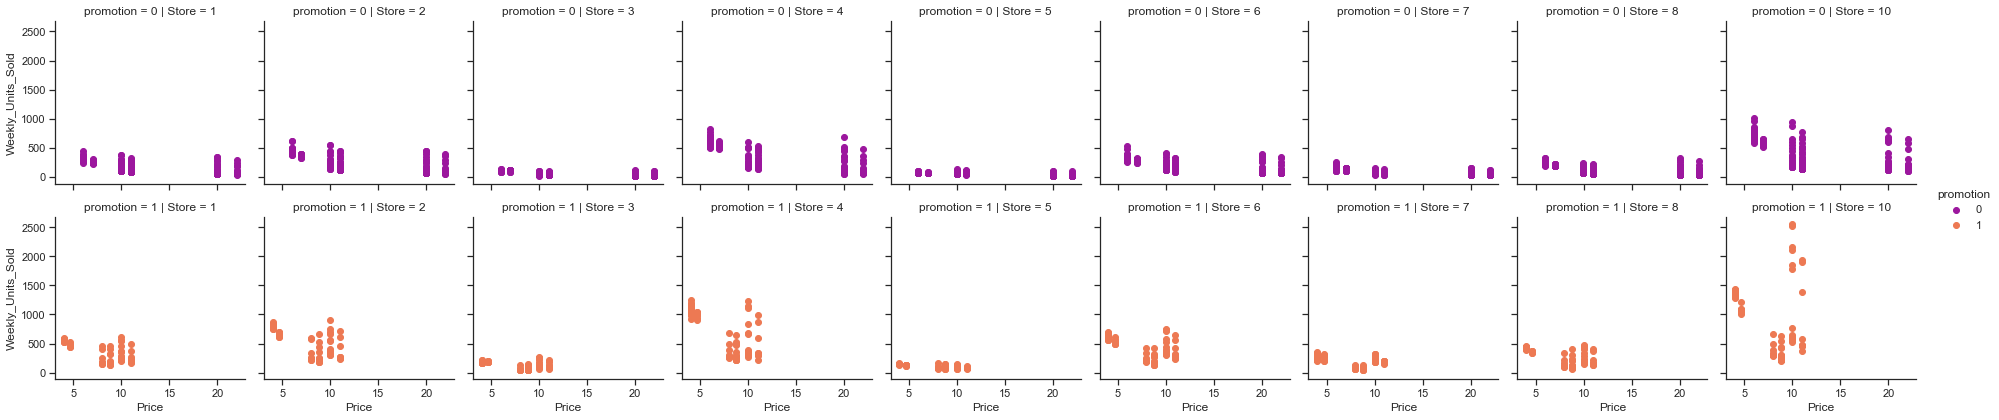

In [26]:
g = sns.FacetGrid(df, col="Store", hue="promotion", palette = 'plasma', row='promotion')
g = (g.map(plt.scatter, "Price", "Weekly_Units_Sold")
     .add_legend())

从上图中我们发现：

所有的商家在优惠或非优惠期间都有相似的价格模式，商家10在优惠期间的销售量最大。

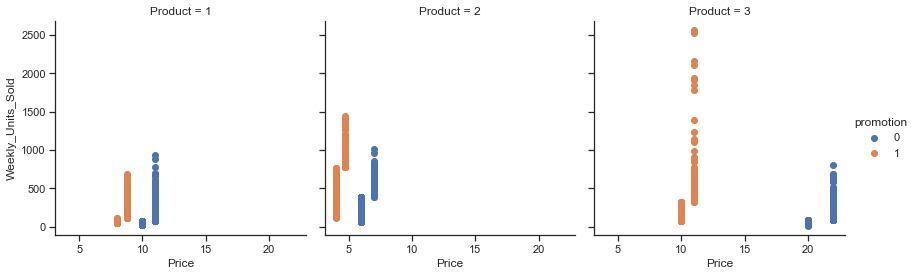

In [27]:
def qqplot(x, y, **kwargs):
    _, xr = stats.probplot(x, fit=False)
    _, yr = stats.probplot(y, fit=False)
    plt.scatter(xr, yr, **kwargs)

g = sns.FacetGrid(df, hue="promotion", col="Product", height=4)    
g.map(qqplot, "Price", "Weekly_Units_Sold")
g.add_legend();

从上图中我们发现：

所有的商品在优惠和非优惠期间存在非常明显的价格差异，商品3在非优惠期间销售量最高。

In [28]:
df.groupby(['Product', 'promotion'])['Price', 'Weekly_Units_Sold'].mean()

Price  Weekly_Units_Sold
Product promotion                              
1       0          10.653866         131.637722
        1           8.523333         199.171296
2       0           6.294348         317.388406
        1           4.201429         581.099206
3       0          20.700744          87.748393
        1          10.409091         400.484848

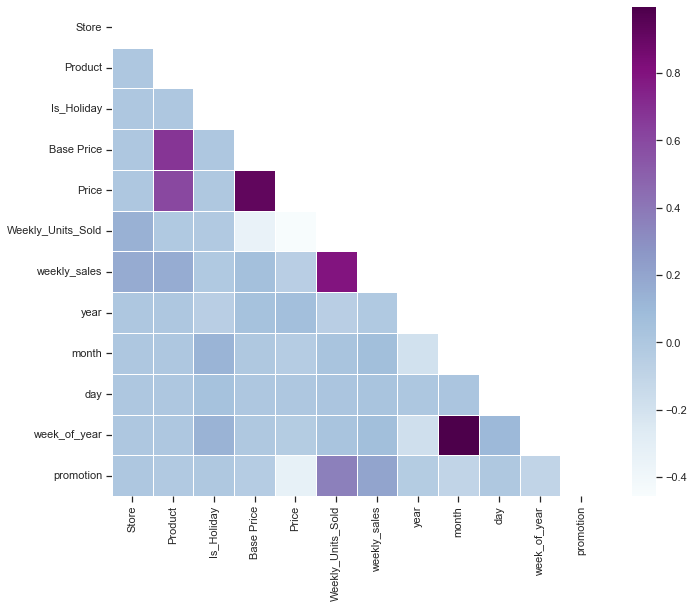

In [29]:
#计算相关系数矩阵
corr_all = df.corr()
mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize = (11, 9))

sns.heatmap(corr_all, mask = mask,
            square = True, linewidths = .5, ax = ax, cmap = "BuPu")      
plt.show();

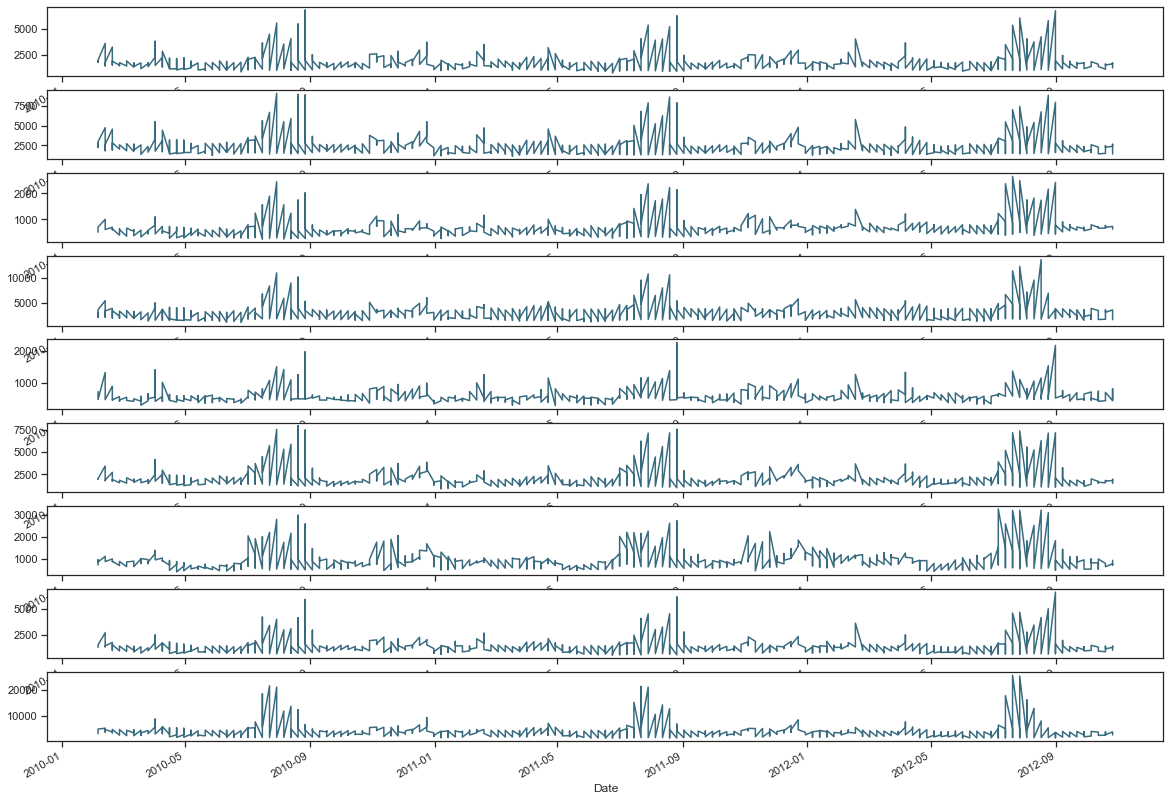

In [30]:
# store types
sales_1 = df[df.Store == 1]['weekly_sales']
sales_2 = df[df.Store == 2]['weekly_sales']
sales_3 = df[df.Store == 3]['weekly_sales']
sales_4 = df[df.Store == 4]['weekly_sales']
sales_5 = df[df.Store == 5]['weekly_sales']
sales_6 = df[df.Store == 6]['weekly_sales']
sales_7 = df[df.Store == 7]['weekly_sales']
sales_8 = df[df.Store == 8]['weekly_sales']
sales_10 = df[df.Store == 10]['weekly_sales']

f, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9) = plt.subplots(9, figsize = (20, 15))

# store types
sales_1.plot(color = c, ax = ax1)
sales_2.plot(color = c, ax = ax2)
sales_3.plot(color = c, ax = ax3)
sales_4.plot(color = c, ax = ax4)
sales_5.plot(color = c, ax = ax5)
sales_6.plot(color = c, ax = ax6)
sales_7.plot(color = c, ax = ax7)
sales_8.plot(color = c, ax = ax8)
sales_10.plot(color = c, ax = ax9);

# 总结

* 1. 商家10的销售量最大，而商家5的销售量最小
* 2. 商品2的销售量在每个月机会都要高于其他商品
* 3. 假期似乎对商家的销售影响不是很大
* 4. 商品2的价格是最便宜,而商品3的价格最贵。
* 5. 大多数商家的销售都收季节性影响,一般都会出现2个高峰
* 6. 2月份商品1的销售量比其他月份略多，4月份产品2的销售量最高，而7月份至9月份的产品3的销售量最高
* 7. 每个产品都有其正常价格和促销价格。产品1和商品2的正常价格和促销价格之间没有明显的差距，但是，商品3的促销价格可以削减到其原始价格的50％。尽管每个商家都对商品3进行了这种降价，但是商家10是降价期间销量最高的商店。
* 8.商家10的商品3在7月至9月间是最畅销的产品。

# 时间序列 Prophet

我们将在商家10建立商品3的时间序列分析，并预测商品3未来50个周的销售额。

In [38]:
store_10_pro_3 = df[(df.Store == 10) & (df.Product == 3)].loc[:, ['Base Price', 'Price', 'Weekly_Units_Sold', 'weekly_sales']]
store_10_pro_3.reset_index(level=0, inplace=True)
fig = px.line(store_10_pro_3, x='Date', y='weekly_sales')
fig.update_layout(title_text='周销售额的时间序列')
fig.show()

ValueError: Could not interpret value `weekly_sales` for parameter `y`

商家10的商品3的周销售额受季节性影响非常大，每年的学校暑假7月至9月都是一个销售高峰。

下面我们要实现一个 prophet模型,并用它来预测未来50周的每周销售量。

关于prophet请参考这个文档：https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html

In [39]:
store_10_pro_3 = store_10_pro_3[['Date', 'weekly_sales']].rename(columns = {'Date': 'ds','weekly_sales': 'y'})

In [40]:
model = Prophet(interval_width = 0.95)
model.fit(store_10_pro_3)
 
future_dates = model.make_future_dataframe(periods = 50, freq='W')

future_dates.tail(7)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.91153


,ds
186,2013-08-25
187,2013-09-01
188,2013-09-08
189,2013-09-15
190,2013-09-22
191,2013-09-29
192,2013-10-06


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      78       366.724   0.000126383       57.8875   1.584e-06       0.001      149  LS failed, Hessian reset 
      99        366.73   2.80067e-05       81.3433      0.7106           1      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     145       366.733   1.67379e-06       71.8149    2.04e-08       0.001      275  LS failed, Hessian reset 
     164       366.733   1.19022e-08       64.8342      0.3088           1      303   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [41]:
forecast = model.predict(future_dates)

# 预测最后一周的日期
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
186,2013-08-25,7157.685559,4768.835369,9357.638224
187,2013-09-01,5539.300832,3296.269115,7888.932722
188,2013-09-08,3698.613349,1179.218306,6200.507939
189,2013-09-15,2423.483805,315.044980,4747.871015
190,2013-09-22,2383.228508,-173.483873,4842.564713
191,2013-09-29,3016.819628,892.714776,5419.852230
192,2013-10-06,3153.900277,840.941414,5481.741126


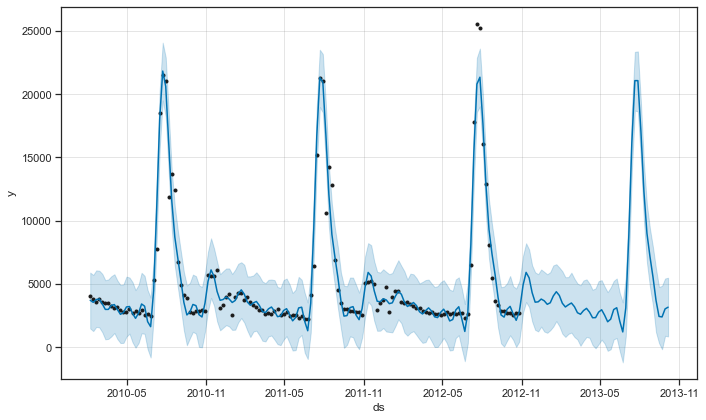

In [42]:
model.plot(forecast);

看来我们的模型能够捕捉到季节性因素,它预测了在2013年7月至9月也有一个销售高峰

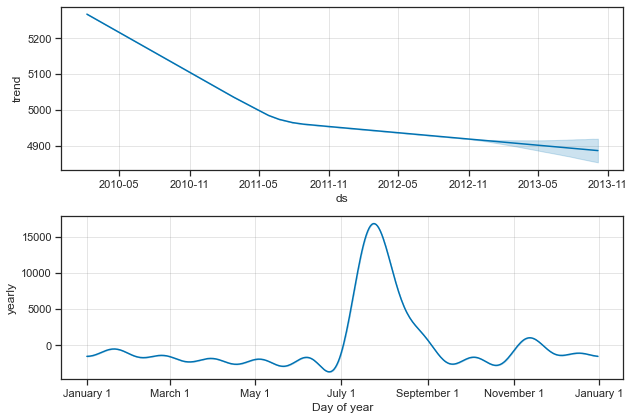

In [43]:
model.plot_components(forecast);

## 评估模型

In [44]:
metric_df = forecast.set_index('ds')[['yhat']].join(store_10_pro_3.set_index('ds').y).reset_index()
metric_df.dropna(inplace=True)
error = mean_squared_error(metric_df.y, metric_df.yhat)
print('The RMSE is {}'. format(sqrt(error)))

The RMSE is 1190.088048153606


# 季节性因素

对于Prophet来说，我们还可以添加自己的自定义假期和节日。在这里，我们将添加从7月初到9月初的学校假期。

In [45]:
def is_school_holiday_season(ds):    
    date = pd.to_datetime(ds)
    starts = datetime.date(date.year, 7, 1)
    ends = datetime.date(date.year, 9, 9)
    return starts < date.to_pydatetime().date() < ends

store_10_pro_3['school_holiday_season'] = store_10_pro_3['ds'].apply(is_school_holiday_season)
store_10_pro_3['not_school_holiday_season'] = ~store_10_pro_3['ds'].apply(is_school_holiday_season)
model = Prophet(interval_width=0.95)

In [46]:
model.add_seasonality(name='school_holiday_season', period=365, fourier_order=3, condition_name='school_holiday_season')
model.add_seasonality(name='not_school_holiday_season', period=365, fourier_order=3, condition_name='not_school_holiday_season')
model.fit(store_10_pro_3)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.91153


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       373.158    0.00260503       89.2779      0.7127      0.7127      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       373.913   3.28948e-06       92.9174       4.526      0.4526      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     221       373.913    4.3189e-08       92.3308      0.3135           1      283   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [47]:
forecast = model.make_future_dataframe(periods=50, freq='W')
forecast['school_holiday_season'] = forecast['ds'].apply(is_school_holiday_season)
forecast['not_school_holiday_season'] = ~forecast['ds'].apply(is_school_holiday_season)

<Figure size 720x360 with 0 Axes>

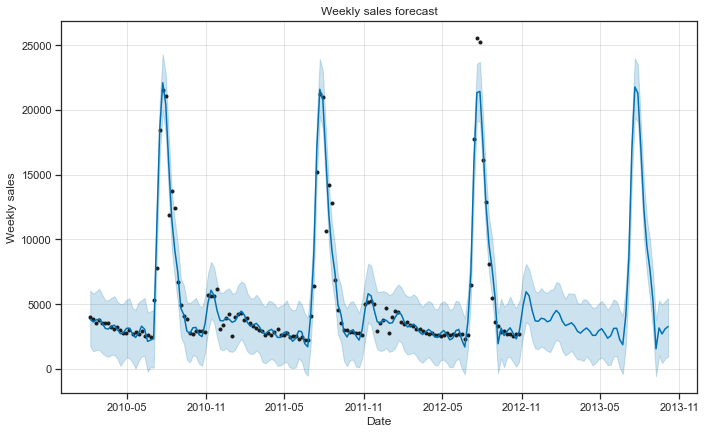

In [48]:
forecast = model.predict(forecast)

plt.figure(figsize=(10, 5))
model.plot(forecast, xlabel = 'Date', ylabel = 'Weekly sales')
plt.title('Weekly sales forecast');

## 评估模型

In [49]:
metric_df = forecast.set_index('ds')[['yhat']].join(store_10_pro_3.set_index('ds').y).reset_index()
metric_df.dropna(inplace=True)
error = mean_squared_error(metric_df.y, metric_df.yhat)
print('The RMSE is {}'. format(sqrt(error)))

The RMSE is 1127.2804770496905


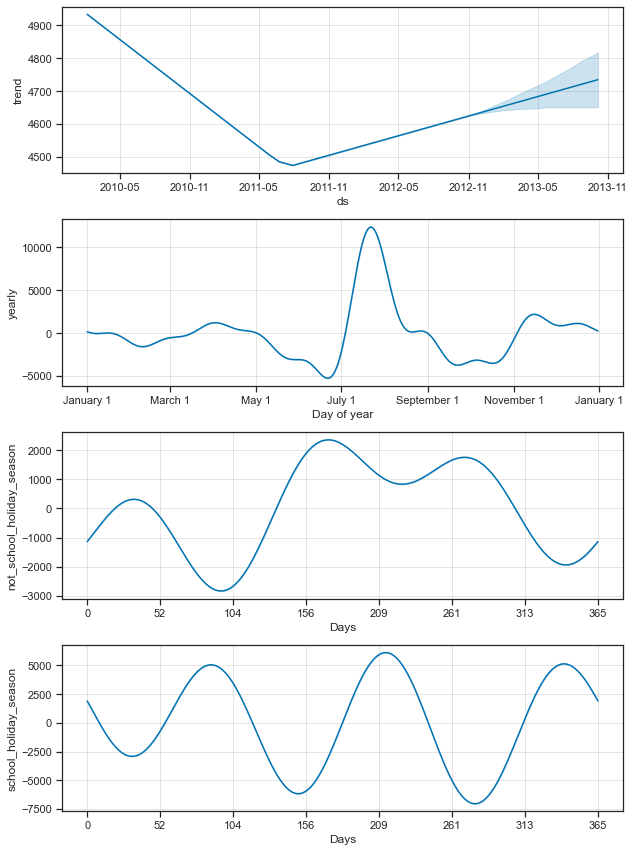

In [50]:
model.plot_components(forecast);

我们通过添加的自定义的假期条件，从而改善了模型的预测表现,模型的均方根误差由原来的：1190 下降到了1120!

参考文档：  
Prophet：https://facebook.github.io/prophet/docs/quick_start.html#python-api    
seaborn：https://seaborn.pydata.org/generated/seaborn.FacetGrid.html
